In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare data

In [2]:
data = pd.read_csv('../../../data/GermanData.csv')

## Drop categorical features
data = data.drop(['1','2','4','5','8','10','11','12','14','15','16','17','18','19','20'],axis=1)


## Drop NULL values
data = data.dropna()

## for dowhy
## Change symbolics to numerics
data['sex'] = np.where(data['sex'] == 'A91', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A92', 0, data['sex'])
data['sex'] = np.where(data['sex'] == 'A93', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A94', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A95', 0, data['sex'])

# mean = data.loc[:,"age"].mean()
# data['age'] = np.where(data['age'] >= mean, 1, 0)
data['age'] = np.where(data['age'] >= 25, 1, 0)
data['credit_history'] = np.where(data['credit_history'] == 'A30', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A31', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A32', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A33', 2, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A34', 3, data['credit_history'])

data['savings'] = np.where(data['savings'] == 'A61', 1, data['savings'])
data['savings'] = np.where(data['savings'] == 'A62', 1, data['savings'])
data['savings'] = np.where(data['savings'] == 'A63', 2, data['savings'])
data['savings'] = np.where(data['savings'] == 'A64', 2, data['savings'])
data['savings'] = np.where(data['savings'] == 'A65', 3, data['savings'])

data['employment'] = np.where(data['employment'] == 'A72', 1, data['employment'])
data['employment'] = np.where(data['employment'] == 'A73', 1, data['employment'])
data['employment'] = np.where(data['employment'] == 'A74', 2, data['employment'])
data['employment'] = np.where(data['employment'] == 'A75', 2, data['employment'])
data['employment'] = np.where(data['employment'] == 'A71', 3, data['employment'])

data['Probability'] = np.where(data['Probability'] == 2, 0, 1)

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

print(non_numeric_columns)

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

protected_attribute = "sex"

print(dataset_orig.head(5))

['credit_history', 'savings', 'employment', 'sex']
   credit_history  savings  employment  sex  age  Probability
0             1.0      1.0         0.5  1.0  1.0          1.0
1             0.0      0.0         0.0  0.0  0.0          0.0
2             1.0      0.0         0.5  1.0  1.0          1.0
3             0.0      0.0         0.5  1.0  1.0          1.0
4             0.5      0.0         0.0  1.0  1.0          0.0


# Transform data using Reweighing

In [2]:
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
protected_attribute = "sex"

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)
X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']


dataset = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)
dataset_orig_train1, weights = dataset_transf.convert_to_dataframe()

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train,sample_weight=weights['instance_weights'])

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

aod :sex -0.03
eod :sex 0.76
SPD: 0.88
DI: 0.96
aod :sex -0.13
eod :sex -0.22
SPD: 0.14
DI: 0.38


In [3]:
index = 0
df = dataset_orig_train.copy()
for i,row in df.iterrows():
    duplicate = round(weights["instance_weights"][int(index)])*10
    for j in range(int(duplicate)):
        df = df.append(row)
    index += 1
print(df.shape)

(7529, 8)
0.6042135745073065
0.274385253058739
0.4535890188124131
0.009828662504980712


# Graph

In [5]:
causal_graph = """
digraph {
credit_history;
savings;
employment;
age;
sex;
Probability;
U[label="Unobserved Confounders"];

sex -> Probability;
sex -> employment; age -> employment; employment -> Probability;
credit_history -> Probability;
age -> savings;
credit_history -> savings; 
savings -> Probability;
U->sex;U->age;U->Probability;
}
"""

## dowhy works for binary inputs only


df['Probability'] = np.where(df['Probability'] == 0, False, True)
df[protected_attribute] = np.where(df[protected_attribute] == 1, True, False)

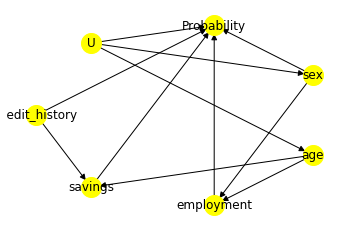

In [6]:
# With graph
model=CausalModel(
        data = df,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()


In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                        
──────(Expectation(Probability|savings,age,credit_history))
d[sex]                                                     
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,savings,age,credit_history,U) = P(Probability|sex,savings,age,credit_history)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [8]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                        
──────(Expectation(Probability|savings,age,credit_history))
d[sex]                                                     
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,savings,age,credit_history,U) = P(Probability|sex,savings,age,credit_history)

## Realized estimand
b: Probability~sex+savings+age+credit_history
Target units: ate

## Estimate
Mean value: 0.03865989509656534

Causal Estimate is 0.03865989509656534


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [14]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.03865989509656534
New effect:0.03946153977614091



# Replace Treatment with Placebo

In [15]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.03865989509656534
New effect:0.0005152015709517247
p value:0.45999999999999996



# Remove Random Subset of Data

In [16]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.03865989509656534
New effect:0.03924966347404479
p value:0.41

